# Before we start

# 3 Major ML/DS breakthroughs of the last decade - 2 decades

1. Trainable convolutions
    - Image classification
    - Image segmentation
    - DeepFake
    - Snapchat
    - Face detection
    - ...
---
    
2. Unsupervised approach to learn words vector representation
    - Sentimental analysis
    - Machine translation
    - Text generation (fake news, fake comment/review)
    - Image captioning
    - Text2Voice, Voice2Text
    - Chat bots

    
---

3. Agent based learning
    - AlphaZero
    - MuZero
    - ...

_Upcoming..._

4. Self-driving cars

---

# DeepWalk

## Idea:

Generate node embeddings by constructing a `words` from nodes using a random walk and running a `word2vec` on a resulting corpora.

---

- Paper https://arxiv.org/pdf/1403.6652.pdf
- Python implementation https://github.com/phanein/deepwalk
- C++ https://github.com/xgfs/deepwalk-c

In [1]:
# install Python implementation

!deepwalk --help

usage: deepwalk [-h] [--debug] [--format FORMAT] --input [INPUT] [-l LOG]
                [--matfile-variable-name MATFILE_VARIABLE_NAME]
                [--max-memory-data-size MAX_MEMORY_DATA_SIZE]
                [--number-walks NUMBER_WALKS] --output OUTPUT
                [--representation-size REPRESENTATION_SIZE] [--seed SEED]
                [--undirected UNDIRECTED] [--vertex-freq-degree]
                [--walk-length WALK_LENGTH] [--window-size WINDOW_SIZE]
                [--workers WORKERS]

optional arguments:
  -h, --help            show this help message and exit
  --debug               drop a debugger if an exception is raised. (default:
                        False)
  --format FORMAT       File format of input file (default: adjlist)
  --input [INPUT]       Input graph file (default: None)
  -l LOG, --log LOG     log verbosity level (default: INFO)
  --matfile-variable-name MATFILE_VARIABLE_NAME
                        variable name of adjacency matrix inside a .mat 

In [2]:
import networkx as nx

In [3]:
# get karate club graph https://en.wikipedia.org/wiki/Zachary%27s_karate_club

karate = nx.karate_club_graph()

In [7]:
nx.adj_matrix(karate).toarray()

array([[0, 1, 1, ..., 1, 0, 0],
       [1, 0, 1, ..., 0, 0, 0],
       [1, 1, 0, ..., 0, 1, 0],
       ...,
       [1, 0, 0, ..., 0, 1, 1],
       [0, 0, 1, ..., 1, 0, 1],
       [0, 0, 0, ..., 1, 1, 0]])

In [8]:
# store as an edgelist

with open('karate.edgelist', 'w') as f:
    for edge in karate.edges:
        f.write(f'{edge[0]} {edge[1]}\n')

In [9]:
# karate_good.embeddings one of the good representations

In [10]:
# run a deepwalk

!deepwalk --seed 41 --representation-size 32 --format edgelist --input karate.edgelist --output karate.embeddings

Number of nodes: 34
Number of walks: 340
Data size (walks*length): 13600
Walking...
Training...


In [11]:
import numpy as np

In [12]:
# load resulting embedding

with open('karate.embeddings', 'r') as f:
    # first line is a header containing `number of nodes` and `embeddings size`
    n, m = map(int, f.readline().split())
    node_embeddings = np.zeros((n, m))
    # remaining lines are node_id and embedding vector components
    for line in f.readlines():   
        node_id, *emb = line.split(' ')
        node_embeddings[int(node_id)] = list(map(float, emb))

In [13]:
import matplotlib.pyplot as plt
%matplotlib inline

In [14]:
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans

In [17]:
node_embeddings.shape

(34, 32)

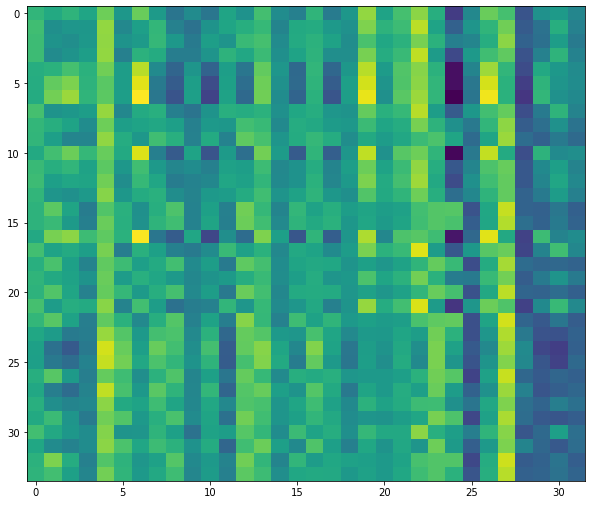

In [18]:
plt.figure(figsize=(10,10))
plt.imshow(node_embeddings, aspect=.8);

In [15]:
node_colors_kmeans = KMeans(4).fit_predict(node_embeddings)

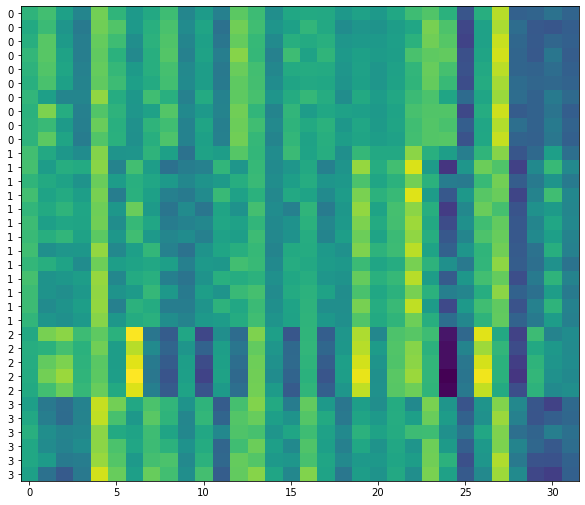

In [19]:
order = np.argsort(node_colors_kmeans)

plt.figure(figsize=(10,10))
plt.imshow(node_embeddings[order, :], aspect=.8);
plt.yticks(ticks = range(34), labels=node_colors_kmeans[order]);

In [20]:
tsne = TSNE(random_state=1, perplexity=5)
node_embeddings_xy = tsne.fit_transform(node_embeddings)

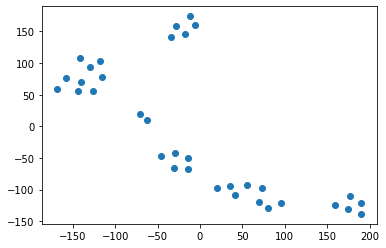

In [33]:
plt.scatter(node_embeddings_xy[:, 0], node_embeddings_xy[:, 1],)# c=node_colors_kmeans);

## Compare to 2 first components of DeepWalk embedding

In [25]:
node_embeddings.shape

(34, 32)

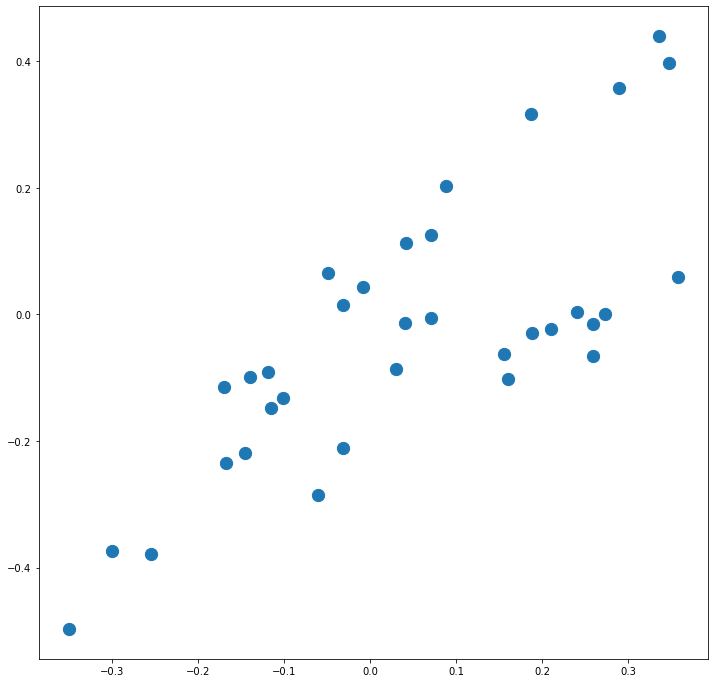

In [32]:
plt.figure(figsize=(12,12))
plt.scatter(node_embeddings[:, 1], node_embeddings[:, 2], s=150)# c=node_colors_kmeans, s=200);

## Compare to Louvain

In [26]:
from community import best_partition

In [27]:
partition_louvain = np.array(list(best_partition(karate).values()))

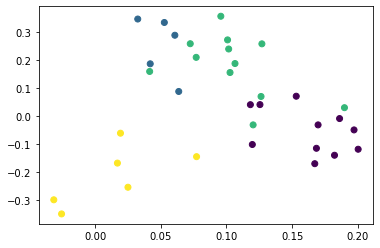

In [28]:
plt.scatter(node_embeddings[:, 0], node_embeddings[:, 1], c=partition_louvain);

In [29]:
from sklearn.metrics import adjusted_rand_score

In [30]:
adjusted_rand_score(node_colors_kmeans, partition_louvain)

0.8064214002859068

## Compare to DeepWalk with embedding size=2

In [34]:
# run a deepwalk

!deepwalk --representation-size 2 --format edgelist --input karate.edgelist --output karate_2.embeddings

Number of nodes: 34
Number of walks: 340
Data size (walks*length): 13600
Walking...
Training...
2020-10-28 16:33:04 WARNING base_any2vec.py: 720 consider setting layer size to a multiple of 4 for greater performance


In [35]:
# load resulting embedding

with open('karate_2.embeddings', 'r') as f:
    # first line is a header containing `number of nodes` and `embeddings size`
    n, m = map(int, f.readline().split())
    node_embeddings_2 = np.zeros((n, m))
    # remaining lines are node_id and embedding vector components
    for line in f.readlines():   
        node_id, *emb = line.split(' ')
        node_embeddings_2[int(node_id)] = list(map(float, emb))

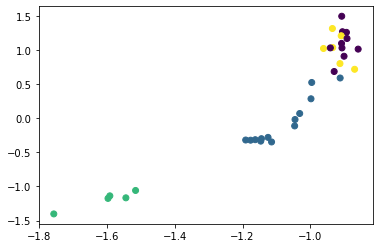

In [36]:
plt.scatter(node_embeddings_2[:, 0], node_embeddings_2[:, 1], c=node_colors_kmeans);

### Conclusion

- To visualize networks' nodes compute DeepWalk embeddings of size 32/64/128 and apply TSNE


## Compare to SpectralClustering

https://arxiv.org/pdf/0711.0189.pdf

In [37]:
# Construct unnormalized Laplacian

A = np.array(nx.adj_matrix(karate).todense())
D = np.diag(A.sum(axis=1))
L = D - A
L_normed = np.linalg.inv(D) @ L

In [48]:
# Compute eigenvalues/eigenvectors of L

values, vectors = np.linalg.eigh(L_normed)
# np.allclose(values[1] * vectors[:, 1], L @ vectors[:, 1])

In [ ]:
34 
34 x 34 -> 34, 34x34
34 x 4 

In [49]:
spectral_embedding = vectors.T

In [50]:
values

array([-0.8138199 ,  0.02306982,  0.20653102,  0.3458712 ,  0.39282758,
        0.54278114,  0.61878676,  0.71784312,  0.75431835,  0.81396716,
        0.8711699 ,  0.95385555,  1.        ,  1.        ,  1.        ,
        1.        ,  1.        ,  1.        ,  1.        ,  1.        ,
        1.        ,  1.        ,  1.08948364,  1.17610518,  1.20956755,
        1.29860472,  1.30147294,  1.54002566,  1.57658134,  1.59702227,
        1.6383949 ,  1.77990428,  1.79330501,  2.57233081])

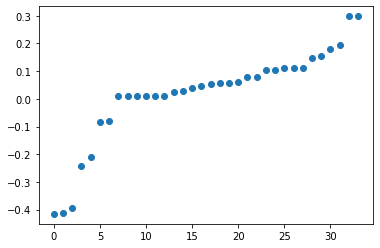

In [51]:
plt.scatter(range(34), sorted(spectral_embedding[1]));

In [52]:
node_colors_spectral = KMeans(4).fit_predict(spectral_embedding[:, :4])

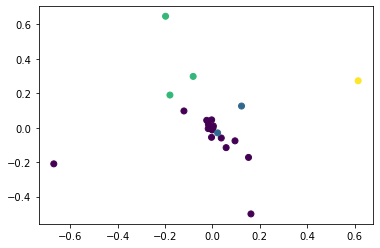

In [53]:
plt.scatter(spectral_embedding[:, 0], spectral_embedding[:, 1], c=node_colors_spectral);

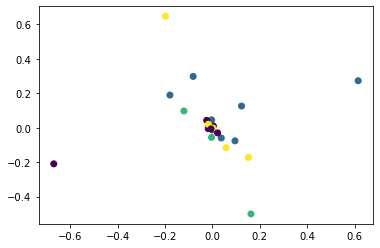

In [54]:
plt.scatter(spectral_embedding[:, 0], spectral_embedding[:, 1], c=node_colors_kmeans);

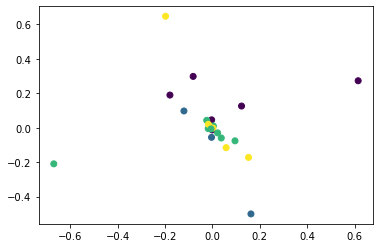

In [55]:
plt.scatter(spectral_embedding[:, 0], spectral_embedding[:, 1], c=partition_louvain);

# Brain network example

In [47]:
adj = np.load('../matrices', allow_pickle=True)
centers = np.load('../node_centers', allow_pickle=True)

for a in adj:
    np.fill_diagonal(a, 0)

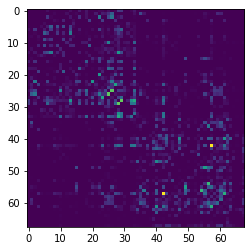

In [56]:
plt.imshow(adj[0])

In [57]:
edge_list = np.vstack(np.nonzero(adj[0])).T

In [58]:
edge_list

array([[ 0,  2],
       [ 0,  4],
       [ 0,  6],
       ...,
       [67, 64],
       [67, 65],
       [67, 66]])

In [59]:
# store as an edgelist

with open('brain.edgelist', 'w') as f:
    for edge in edge_list:
        f.write(f'{edge[0]} {edge[1]}\n')

In [63]:
# run a deepwalk

!deepwalk --seed 41 --representation-size 32 --format edgelist --input brain.edgelist --output brain.embeddings

Number of nodes: 68
Number of walks: 680
Data size (walks*length): 27200
Walking...
Training...


In [64]:
# load resulting embedding

with open('brain.embeddings', 'r') as f:
    # first line is a header containing `number of nodes` and `embeddings size`
    n, m = map(int, f.readline().split())
    brain_node_embeddings = np.zeros((n, m))
    # remaining lines are node_id and embedding vector components
    for line in f.readlines():   
        node_id, *emb = line.split(' ')
        brain_node_embeddings[int(node_id)] = list(map(float, emb))

In [65]:
c = [0]*34 + [1]*34

In [69]:
tsne = TSNE(random_state=1, perplexity=10)
node_embeddings_xy = tsne.fit_transform(brain_node_embeddings)

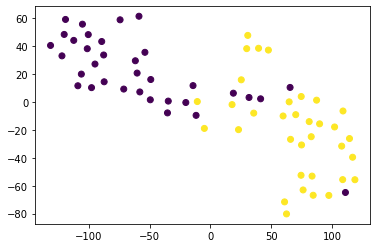

In [72]:
plt.scatter(node_embeddings_xy[:, 0], node_embeddings_xy[:, 1], c=c);

# What is next?

- Node2Vec
- VERSE